In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed, Conv1D, Flatten
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.switch_backend('TkAgg')
%matplotlib inline

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

np.random.seed(7)


Using TensorFlow backend.


In [2]:
# usuful functions


def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]


def create_datasets(dataset, look_back=1, look_ahead=1, jump=1):
    data_x, data_y = [], []
    for i in range(0, len(dataset)-look_back-look_ahead+1, jump):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)


def reverse_scale(data, mean, std):
    return data*std + mean


def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score


def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100


def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print(i+1, "  ->  ", score)
        
    return score


def plot_errors(pred_test, test_y, errors):
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.plot(test_y[:,23,:], label="Observed")
    plt.plot(pred_test[:,23,:], color="red", label="Predicted, MAPE: "+ str(round(errors[23], 5))+"%")
    plt.title("24 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(312)
    plt.plot(pred_test[:,47,:], color="red", label="Predicted, MAPE: "+ str(round(errors[47], 5))+"%")
    plt.plot(test_y[:,47,:], label="Observed")
    plt.title("48 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(313)
    plt.plot(pred_test[:,71,:], color="red", label="Predicted, MAPE: "+ str(round(errors[71], 5))+"%")
    plt.plot(test_y[:,71,:], label="Observed")
    plt.title("72 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.tight_layout()
    plt.show()
    

def build_seq2seq_model(look_ahead=1):
    m = Sequential()
    
    # encoder
    m.add(GRU(16, input_shape=(None, 1)))
    # m.add(GRU(16, input_dim = 1))
    
    # repeat for the number of steps out
    m.add(RepeatVector(look_ahead))
    
    # decoder
    m.add(GRU(8, return_sequences=True))
    m.add(GRU(8, return_sequences=True))
    
    # split the output into timesteps
    m.add(TimeDistributed(Dense(1)))
    
    m.compile(loss='mse', optimizer='rmsprop')
    
    m.summary()
    return m


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()

# CNN

In [6]:
# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
river = all_levels[:, 5]
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

In [7]:
scores = []
history = []
model_list = []
river_i_list = [5]
# look_back = 24*30 * 24
look_ahead = 72
N = 24*7*21 * look_ahead
split = 0.8
batch_size=1200
epochs=20
river = all_levels[:N, 5]  # zgz

# normalize
river_mean, river_std = river.mean(), river.std()
river = preprocessing.scale(river)[:, None]

In [8]:
# split data into train and test subsets
train, test = train_test_split(river, split)

In [9]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps, jump=0):
    X, y = list(), list()
    last_idx = len(sequence)-jump-1
    for i in range(last_idx):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > last_idx:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+jump]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [10]:
# choose a number of time steps
n_steps = 1000
# split into samples
train = scaler.fit_transform(train)
X, y = split_sequence(train, n_steps, jump=72)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

In [11]:
X.shape

(75612, 1000, 1)

In [12]:
y.shape

(75612, 1)

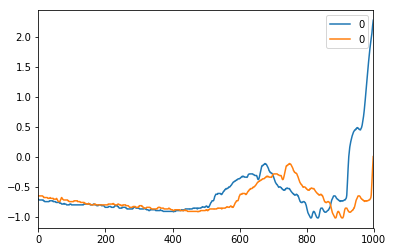

In [13]:
ax = pd.DataFrame(y[:1000]).plot(label="y")
pd.DataFrame(X[:1000,-1,0]).plot(ax=ax)

In [18]:
# MODEL
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=200, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=20, kernel_size=200, activation='relu'))
model.add(Conv1D(filters=20, kernel_size=100, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 901, 64)           6464      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 450, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 431, 20)           25620     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 422, 20)           4020      
_________________________________________________________________
flatten_2 (Flatten)          (None, 8440)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               844100    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [19]:
history = model.fit(
    x=X, 
    y=y, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=2,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=2, mode='auto')]
)

Train on 60489 samples, validate on 15123 samples
Epoch 1/20
 - 242s - loss: 0.8659 - val_loss: 0.5040
Epoch 2/20
 - 240s - loss: 0.3343 - val_loss: 0.4584
Epoch 3/20
 - 238s - loss: 0.2833 - val_loss: 0.3972
Epoch 4/20
 - 242s - loss: 0.2451 - val_loss: 0.3838
Epoch 5/20
 - 241s - loss: 0.2004 - val_loss: 0.3843
Epoch 6/20
 - 238s - loss: 0.1635 - val_loss: 0.4485
Epoch 7/20
 - 238s - loss: 0.1331 - val_loss: 0.4641
Epoch 8/20
 - 237s - loss: 0.1118 - val_loss: 0.4924
Epoch 9/20
 - 237s - loss: 0.0906 - val_loss: 0.5816
Epoch 10/20
 - 238s - loss: 0.0807 - val_loss: 0.5443
Epoch 11/20
 - 238s - loss: 0.0711 - val_loss: 0.5501
Epoch 12/20
 - 237s - loss: 0.0637 - val_loss: 0.5579
Epoch 13/20
 - 237s - loss: 0.0564 - val_loss: 0.5404
Epoch 14/20
 - 238s - loss: 0.0489 - val_loss: 0.5579
Epoch 00014: early stopping


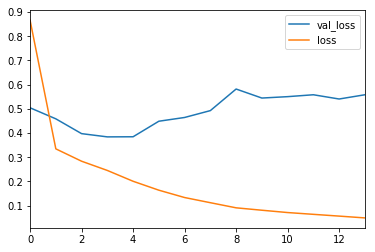

In [20]:
pd.DataFrame(history.history).plot()

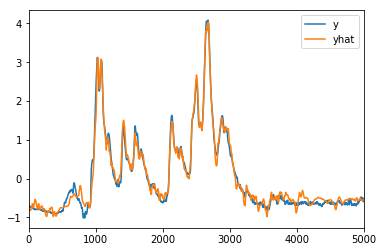

In [21]:
yhat=model.predict(X)

ax = pd.DataFrame(y[:5000], columns=["y"]).plot()
pd.DataFrame(yhat[:5000], columns=["yhat"]).plot(ax=ax)

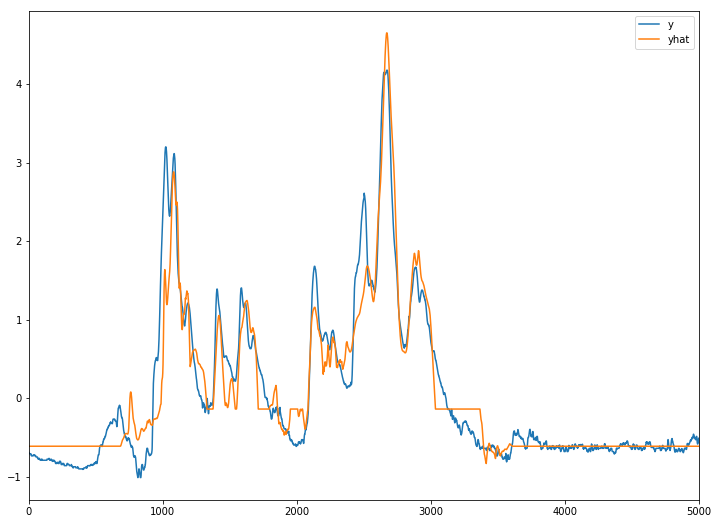

In [141]:
yhat=model.predict(X)

ax = pd.DataFrame(y[:5000], columns=["y"]).plot()
pd.DataFrame(yhat[:5000], columns=["yhat"]).plot(ax=ax)

In [157]:
np.mean(X.flat)

0.03261622810330724

In [158]:
scaler.fit_transform(X.flatten()[:, None])

1.1821554685796353e-16

In [166]:
test_ = scaler.transform(test)

In [168]:
test_

array([[-0.74889128],
       [-0.74889128],
       [-0.74889128],
       ...,
       [-0.31706789],
       [-0.31706789],
       [-0.31706789]])

In [20]:
# choose a number of time steps
n_steps = 1000
# split into samples
_test = scaler.fit_transform(test)
test_X, test_y = split_sequence(_test, n_steps, jump=72)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

In [19]:
test_X.shape

NameError: name 'test_X' is not defined

In [25]:
test_yhat = model.predict(test_X)

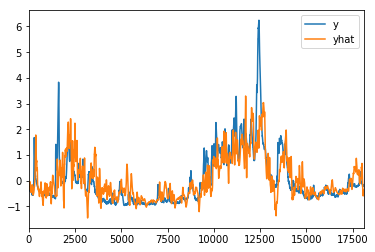

In [26]:
ax = pd.DataFrame(test_y, columns=["y"]).plot()
pd.DataFrame(test_yhat, columns=["yhat"]).plot(ax=ax)

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mean_squared_error(test_y, test_yhat)

0.46327723859903686

In [ ]:
test

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_ytrue[:, 71, 0], label="Real")
plt.plot(train_yhat[:, 71, 0], label="Prediction")
plt.title("Train")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(test_ytrue[:, 71, 0], label="Real")
plt.plot(test_yhat[:, 71, 0], label="Prediction")
plt.title("Test")
plt.legend()
plt.show()

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
pd.DataFrame(history.history).plot()
plt.show()

In [53]:
# MODEL
# define model
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=36, activation='relu', input_shape=(n_steps, n_features)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=16, kernel_size=24, activation='relu'))
model2.add(Conv1D(filters=8, kernel_size=12, activation='relu'))
model2.add(Flatten())
model2.add(Dense(24, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 965, 32)           1184      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 482, 32)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 459, 16)           12304     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 448, 8)            1544      
_________________________________________________________________
flatten_7 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                86040     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 25        
Total para

In [54]:
history2 = model2.fit(
    x=X, 
    y=y, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=2,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=3, verbose=2, mode='auto')]
)

Train on 60489 samples, validate on 15123 samples
Epoch 1/20
 - 168s - loss: 0.4203 - val_loss: 0.4586
Epoch 2/20
 - 162s - loss: 0.2889 - val_loss: 0.4041
Epoch 3/20
 - 168s - loss: 0.2492 - val_loss: 0.3642
Epoch 4/20
 - 211s - loss: 0.2138 - val_loss: 0.3807
Epoch 5/20
 - 184s - loss: 0.1859 - val_loss: 0.3933
Epoch 6/20
 - 168s - loss: 0.1560 - val_loss: 0.4154
Epoch 7/20
 - 170s - loss: 0.1366 - val_loss: 0.4344
Epoch 8/20
 - 173s - loss: 0.1196 - val_loss: 0.4811
Epoch 9/20
 - 170s - loss: 0.1069 - val_loss: 0.4557
Epoch 10/20
 - 165s - loss: 0.0968 - val_loss: 0.4728
Epoch 11/20
 - 162s - loss: 0.0904 - val_loss: 0.5266
Epoch 12/20
 - 162s - loss: 0.0847 - val_loss: 0.5264
Epoch 13/20
 - 163s - loss: 0.0755 - val_loss: 0.5477
Epoch 00013: early stopping


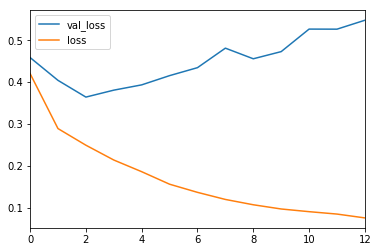

In [55]:
pd.DataFrame(history2.history).plot()

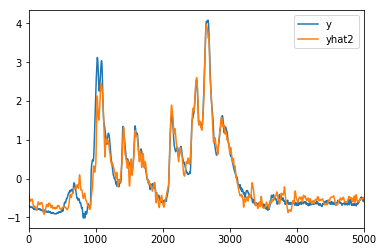

In [56]:
yhat2=model2.predict(X)

ax = pd.DataFrame(y[:5000], columns=["y"]).plot()
pd.DataFrame(yhat2[:5000], columns=["yhat2"]).plot(ax=ax)

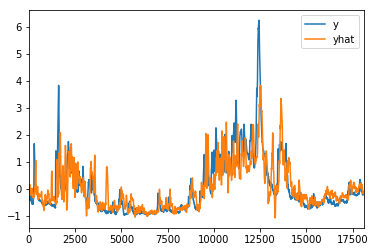

In [57]:
test_yhat2 = model2.predict(test_X)

ax = pd.DataFrame(test_y, columns=["y"]).plot()
pd.DataFrame(test_yhat2, columns=["yhat"]).plot(ax=ax)

In [58]:
mean_squared_error(test_yhat2, test_y)

0.41111525055001247

In [50]:
mean_squared_error(test_yhat, test_y)

0.46327723859903686

In [37]:
# MODEL
from keras import regularizers
# define model
model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=36, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=regularizers.l2(0.01)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=16, kernel_size=24, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model3.add(Conv1D(filters=16, kernel_size=24, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model3.add(Conv1D(filters=16, kernel_size=24, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Conv1D(filters=8, kernel_size=12, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Flatten())
# model3.add(Dense(6, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
model3.summary()

history3 = model3.fit(
    x=X, 
    y=y, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=2,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=3, verbose=2, mode='auto')]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 965, 32)           1184      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 482, 32)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 459, 16)           12304     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 448, 8)            1544      
_________________________________________________________________
flatten_3 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3585      
Total params: 18,617
Trainable params: 18,617
Non-trainable params: 0
_________________________________________________________________
Train 

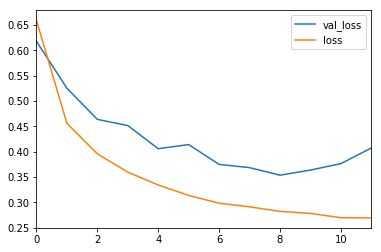

In [38]:
pd.DataFrame(history3.history).plot()

In [39]:
yhat3=model3.predict(X)

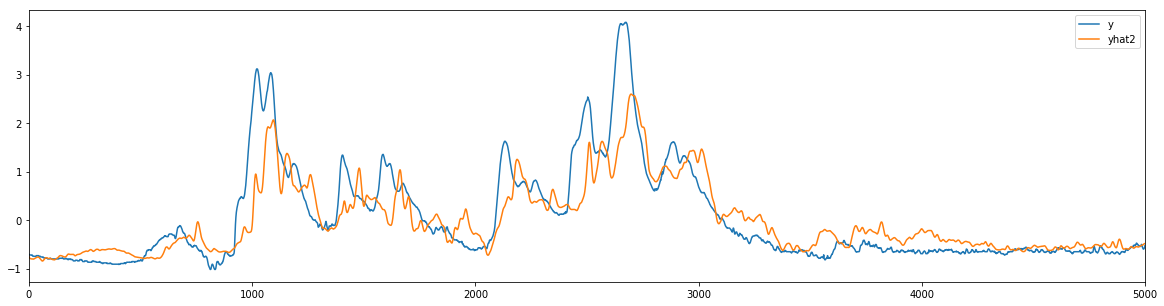

In [40]:
ax = pd.DataFrame(y[:5000], columns=["y"]).plot(figsize=(20,5))
pd.DataFrame(yhat3[:5000], columns=["yhat2"]).plot(ax=ax)

In [41]:
test_yhat3 = model3.predict(test_X)

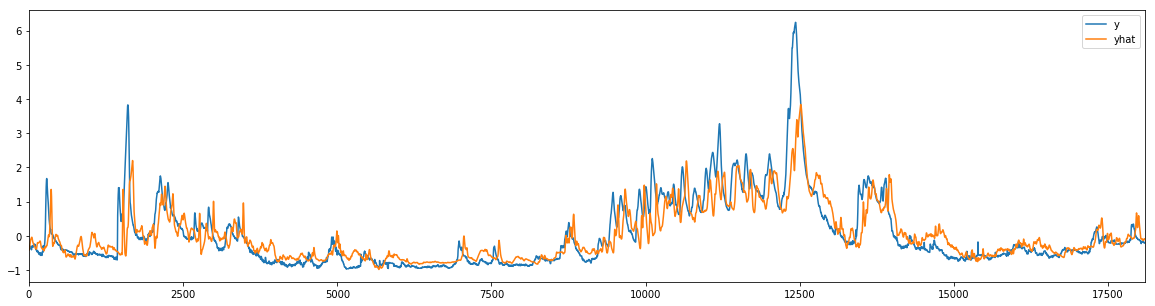

In [42]:
ax = pd.DataFrame(test_y, columns=["y"]).plot(figsize=(20,5))
pd.DataFrame(test_yhat3, columns=["yhat"]).plot(ax=ax)

In [43]:
mean_squared_error(test_yhat3, test_y)

0.3180312810958889

In [44]:
from uuid import uuid4

with open("CNN-%s.pkl" % str(uuid4())[:8], "wb") as f:
    import pickle
    pickle.dump(model3, f)

In [35]:
m = pickle.load(open("CNN-e98edec2.pkl", "rb"))
m2 = pickle.load(open("CNN-aae86f70.pkl", "rb"))


In [36]:
m2.predict(test_X[:10])

array([[-0.35204282],
       [-0.35273597],
       [-0.35315976],
       [-0.35152054],
       [-0.35006872],
       [-0.34611157],
       [-0.34276772],
       [-0.3369449 ],
       [-0.3318781 ],
       [-0.32432088]], dtype=float32)